# RNN Tutorial

Included in the data/names directory are 18 text files named as “[Language].txt”. Each file contains a bunch of names, one name per line, mostly romanized (but we still need to convert from Unicode to ASCII).

We’ll end up with a dictionary of lists of names per language, {language: [names ...]}. The generic variables “category” and “line” (for language and name in our case) are used for later extensibility.

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import torch
import math

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Arabic.txt', 'data/names/Chinese.txt', 'data/names/Czech.txt', 'data/names/Dutch.txt', 'data/names/English.txt', 'data/names/French.txt', 'data/names/German.txt', 'data/names/Greek.txt', 'data/names/Irish.txt', 'data/names/Italian.txt', 'data/names/Japanese.txt', 'data/names/Korean.txt', 'data/names/Polish.txt', 'data/names/Portuguese.txt', 'data/names/Russian.txt', 'data/names/Scottish.txt', 'data/names/Spanish.txt', 'data/names/Vietnamese.txt']
Slusarski


Now we have category_lines, a dictionary mapping each category (language) to a list of lines (names). We also kept track of all_categories (just a list of languages) and n_categories for later reference.

In [2]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


### Turning Names into Tensors
Now that we have all the names organized, we need to turn them into Tensors to make any use of them.

To represent a single letter, we use a “one-hot vector” of size <1 x n_letters>. A one-hot vector is filled with 0s except for a 1 at index of the current letter, e.g. "b" = <0 1 0 0 0 ...>.

To make a word we join a bunch of those into a 2D matrix <line_length x 1 x n_letters>.

That extra 1 dimension is because PyTorch assumes everything is in batches - we’re just using a batch size of 1 here.

In [3]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


### Creating the Network
Before autograd, creating a recurrent neural network in Torch involved cloning the parameters of a layer over several timesteps. The layers held hidden state and gradients which are now entirely handled by the graph itself. This means you can implement a RNN in a very “pure” way, as regular feed-forward layers.

This RNN module (mostly copied from the PyTorch for Torch users tutorial) is just 2 linear layers which operate on an input and hidden state, with a LogSoftmax layer after the output.

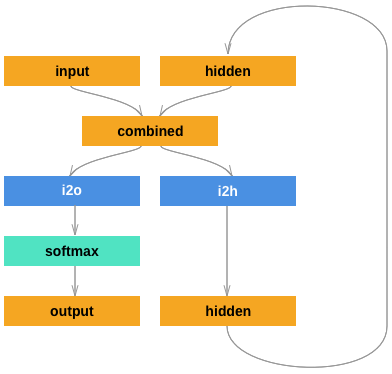

In [4]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [5]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.isLSTM = False

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)  # input_size + hidden_size -> hidden_size
        self.i2o = nn.Linear(input_size + hidden_size, output_size)  # input_size + hidden_size -> output_size
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)  # 连接input和hidden
        hidden = self.i2h(combined)  # hidden就在一直更新
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)
print(rnn)

RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [6]:

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.isLSTM = True

        self.hidden_size = hidden_size

        self.rnn = nn.LSTM(input_size, hidden_size)  # pytorch封装好了
        self.out = nn.Linear(hidden_size, output_size)  # 由hidden_size -> output_size
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, input, h, c):
#         combined = torch.cat((input, hidden), 1)
        out, (h, c) = self.rnn(input, (h, c))
        output = self.out(out)
        output = self.softmax(output)
        return output, h, c

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size), torch.zeros(1, 1, self.hidden_size)

n_hidden = 128
lstm = LSTM(n_letters, n_hidden, n_categories)
print(lstm)

LSTM(
  (rnn): LSTM(57, 128)
  (out): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=-1)
)


To run a step of this network we need to pass an input (in our case, the Tensor for the current letter) and a previous hidden state (which we initialize as zeros at first). We’ll get back the output (probability of each language) and a next hidden state (which we keep for the next step).

In [7]:
import random
import time
import torch.nn as nn

In [8]:
input = letterToTensor('A')
print(input.size())
hidden = torch.zeros(1, n_hidden)

h = rnn.initHidden()
output,next_h= rnn(input, h)
print(output.shape)
print(next_h.shape)

torch.Size([1, 57])
torch.Size([1, 18])
torch.Size([1, 128])


For the sake of efficiency we don’t want to be creating a new Tensor for every step, so we will use lineToTensor instead of letterToTensor and use slices. This could be further optimized by pre-computing batches of Tensors.

In [9]:
input = lineToTensor('Albert')  # (6, 1, 57)
print(input.size())
hidden = torch.zeros(1, n_hidden)

h = rnn.initHidden()
output, h = rnn(input[0], h)
print(torch.exp(output))

torch.Size([6, 1, 57])
tensor([[0.0522, 0.0587, 0.0543, 0.0586, 0.0566, 0.0514, 0.0589, 0.0545, 0.0573,
         0.0570, 0.0525, 0.0598, 0.0552, 0.0596, 0.0546, 0.0558, 0.0523, 0.0507]],
       grad_fn=<ExpBackward0>)


As you can see the output is a <1 x n_categories> Tensor, where every item is the likelihood of that category (higher is more likely).

### Preparing for Training
Before going into training we should make a few helper functions. The first is to interpret the output of the network, which we know to be a likelihood of each category. We can use Tensor.topk to get the index of the greatest value:

In [27]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('German', 6)


We will also want a quick way to get a training example (a name and its language):

In [28]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = French / line = Royer
category = Spanish / line = Quiros
category = French / line = Moulin
category = Greek / line = Fourakis
category = French / line = Denis
category = Scottish / line = Macleod
category = Dutch / line = Merckx
category = Greek / line = Nomikos
category = Russian / line = Pavlychev
category = Russian / line = Isasev


### Training the Network
Now all it takes to train this network is show it a bunch of examples, have it make guesses, and tell it if it’s wrong.

For the loss function nn.NLLLoss is appropriate, since the last layer of the RNN is nn.LogSoftmax.

In [29]:
criterion = nn.NLLLoss()

Each loop of training will:

- Create input and target tensors
- Create a zeroed initial hidden state
- Read each letter in and keep hidden state for next letter
- Compare final output to target
- Back-propagate
- Return the output and loss

In [30]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor, net):
    if net.isLSTM == True:
        h0, c0 = net.initHidden()
    else:
        h0 = net.initHidden()

    net.zero_grad()

    if net.isLSTM == True:
        # 直接输入整个句子就可以，pytorch会自动处理
        output, h, c = net(line_tensor, h0, c0)
    else:
        # 一次输入一个字符
        for i in range(line_tensor.size()[0]):
            output, h0 = net(line_tensor[i], h0)

    if net.isLSTM == True:
        loss = criterion(output[-1], category_tensor)  # 取最后一个输出
    else:
        loss = criterion(output, category_tensor)
    loss.backward()  # 计算梯度

    # Add parameters' gradients to their values, multiplied by learning rate
    # 没有使用optimizer，手动更新参数
    for p in net.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [14]:
from My_LSTM import LSTMModel
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = criterion.to(device)

n_hidden = 128
my_lstm = LSTMModel(n_letters, n_hidden, n_categories).to(device)  # 
print(my_lstm)
input = lineToTensor('Albert')  # (6, 1, 57)
input = input.to(device)  # ⬅️ 把 input 转到模型所在设备
print(input.shape)
h, c = my_lstm.init_hidden(1)
output, h, c = my_lstm(input, h, c)
print(torch.exp(output))

LSTMModel(
  (lstm): LSTMBlock()
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=18, bias=True)
    (1): LogSoftmax(dim=1)
  )
)
torch.Size([6, 1, 57])
tensor([[0.0565, 0.0530, 0.0516, 0.0536, 0.0549, 0.0593, 0.0572, 0.0535, 0.0600,
         0.0524, 0.0595, 0.0589, 0.0559, 0.0568, 0.0549, 0.0589, 0.0518, 0.0513],
        [0.0561, 0.0530, 0.0517, 0.0539, 0.0554, 0.0592, 0.0582, 0.0536, 0.0605,
         0.0519, 0.0591, 0.0592, 0.0564, 0.0564, 0.0547, 0.0582, 0.0515, 0.0510],
        [0.0563, 0.0532, 0.0513, 0.0543, 0.0563, 0.0592, 0.0573, 0.0539, 0.0600,
         0.0527, 0.0583, 0.0580, 0.0561, 0.0568, 0.0553, 0.0588, 0.0516, 0.0507],
        [0.0562, 0.0526, 0.0518, 0.0540, 0.0554, 0.0586, 0.0572, 0.0544, 0.0601,
         0.0527, 0.0595, 0.0585, 0.0559, 0.0567, 0.0553, 0.0588, 0.0509, 0.0515],
        [0.0568, 0.0529, 0.0509, 0.0547, 0.0554, 0.0590, 0.0577, 0.0537, 0.0599,
         0.0519, 0.0599, 0.0594, 0.0555, 0.0561, 0.0546, 0.0596, 0.0510, 0.0508],
       

In [16]:
import torch.optim as optim
import time
import math
learning_rate = 0.1 
n_iters = 300000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
current_accuracy = 0
all_losses = []
all_accuracy = []

start = time.time()

optimizer = optim.SGD(my_lstm.parameters(), lr=learning_rate)


# 用于计算时间
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def train(category_tensor, line_tensor):
    # 确保数据也在相同 device 上
    category_tensor = category_tensor.to(device)
    line_tensor = line_tensor.to(device)

    # 初始化 hidden 状态
    hidden1, hidden2 = my_lstm.init_hidden(batch_size=1)
    
    # 梯度清零
    my_lstm.zero_grad()

    # 转换形状为 (batch, seq_len, input_size)
    line_tensor = line_tensor.transpose(0, 1)

    # 前向传播
    output, hidden1, hidden2 = my_lstm(line_tensor, hidden1, hidden2)

    # 计算 loss，反向传播
    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()

    return output, loss.item()

    
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    guess, guess_i = categoryFromOutput(output)
    if guess == category:
        current_accuracy += 1

    if iter % print_every == 0:
        correct = '✓' if guess == category else f'✗ ({category})'
        print(f'{iter} {iter / n_iters * 100:.2f}% ({timeSince(start)}) '
              f'Loss: {loss:.4f} | "{line}" -> {guess} {correct}')

    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        all_accuracy.append(current_accuracy / plot_every)
        current_loss = 0
        current_accuracy = 0


5000 1.67% (0m 32s) Loss: 1.7654 | "O'Hannagain" -> Scottish ✗ (Irish)
10000 3.33% (1m 3s) Loss: 2.3210 | "Ianson" -> Scottish ✗ (English)
15000 5.00% (1m 34s) Loss: 0.9605 | "Arendonk" -> Dutch ✓
20000 6.67% (2m 4s) Loss: 0.0532 | "Dubicki" -> Polish ✓
25000 8.33% (2m 35s) Loss: 4.4877 | "Torres" -> Portuguese ✗ (Spanish)
30000 10.00% (3m 5s) Loss: 0.0130 | "Andrusiv" -> Russian ✓
35000 11.67% (3m 35s) Loss: 0.0005 | "Vassilopulos" -> Greek ✓
40000 13.33% (4m 6s) Loss: 1.4685 | "Cruz" -> Spanish ✗ (Portuguese)
45000 15.00% (4m 36s) Loss: 1.4916 | "Bran" -> Irish ✓
50000 16.67% (5m 6s) Loss: 0.1827 | "Farber" -> German ✓
55000 18.33% (5m 36s) Loss: 0.0007 | "Kalakos" -> Greek ✓
60000 20.00% (6m 7s) Loss: 0.0027 | "Cablikova" -> Czech ✓
65000 21.67% (6m 37s) Loss: 3.2258 | "Hout" -> German ✗ (Dutch)
70000 23.33% (7m 7s) Loss: 0.0051 | "Pasternack" -> Polish ✓
75000 25.00% (7m 38s) Loss: 0.0997 | "Gensai" -> Japanese ✓
80000 26.67% (8m 8s) Loss: 0.0987 | "Kijek" -> Polish ✓
85000 28.33% 

In [34]:

import torch.optim as optim
criterion = nn.NLLLoss()
learning_rate = 0.1 # If you set this too high, it might explode. If too low, it might not learn

optimizer = optim.SGD(my_lstm.parameters(), lr=learning_rate)
def train(category_tensor, line_tensor):
    hidden1, hidden2 = my_lstm.init_hidden()
    my_lstm.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden1, hidden2 = my_lstm(line_tensor[i], hidden1,hidden2)

    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()
    return output, loss.item()

In [ ]:
import time
import math
# Keep track of losses for plotting
current_loss = 0
current_accuracy = 0
all_losses = []
all_accuracy = []

start = time.time()
# 迭代和打印的设置
n_iters = 500000
print_every = 5000
plot_every = 1000

# 用于计算时间
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    # 添加准确率accuracy
    guess, guess_i = categoryFromOutput(output)
    if guess == category:
        current_accuracy +=1

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        all_accuracy.append(current_accuracy/plot_every)
        current_loss = 0
        current_accuracy = 0

5000 1% (0m 30s) 2.9522 Kruse / Dutch ✗ (German)
10000 2% (1m 0s) 2.8448 Crespo / Greek ✗ (Portuguese)
15000 3% (1m 29s) 2.7700 Wang / Spanish ✗ (Chinese)


In [18]:
loss_lstm_my=all_losses
accuracy_lstm_my=all_accuracy

Now we just have to run that with a bunch of examples. Since the train function returns both the output and loss we can print its guesses and also keep track of loss for plotting. Since there are 1000s of examples we print only every print_every examples, and take an average of the loss.

In [25]:
# 迭代和打印的设置
n_iters = 500000
print_every = 5000
plot_every = 1000

# 用于计算时间
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def train_and_print(net):
    # Keep track of losses & accuracies for plotting
    current_loss = 0
    current_accuracy = 0
    all_losses = []
    all_accuracy = []
    start = time.time()

    for iter in range(1, n_iters + 1):
        category, line, category_tensor, line_tensor = randomTrainingExample()
        output, loss = train(category_tensor, line_tensor, net)
        
        current_loss += loss
        if net.isLSTM == True:
            guess, guess_i = categoryFromOutput(output[-1])
        else:
            guess, guess_i = categoryFromOutput(output)
        if guess == category:
            current_accuracy += 1

        # Print iter number, loss, name and guess
        if iter % print_every == 0:
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

        # Add current loss avg to list of losses
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            all_accuracy.append(current_accuracy / plot_every)
            current_loss = 0
            current_accuracy = 0
    return all_losses, all_accuracy

In [31]:
loss_lstm, accucay_lstm = train_and_print(lstm)

5000 1% (0m 13s) 2.8099 Oleastro / English ✗ (Spanish)
10000 2% (0m 24s) 2.7673 Sergeant / French ✓
15000 3% (0m 35s) 2.7522 Bouchard / Arabic ✗ (French)
20000 4% (0m 47s) 2.7403 Lethbridge / English ✓
25000 5% (0m 58s) 2.8750 Kolman / Irish ✗ (Czech)
30000 6% (1m 9s) 2.5552 Abelli / Czech ✗ (Italian)
35000 7% (1m 21s) 1.4893 Shin / Vietnamese ✗ (Korean)
40000 8% (1m 32s) 4.3664 Tenshin / English ✗ (Japanese)
45000 9% (1m 43s) 2.3019 Shimon / Arabic ✗ (Japanese)
50000 10% (1m 54s) 1.2585 Nowak / Polish ✓
55000 11% (2m 4s) 2.9195 Mackay / Russian ✗ (Scottish)
60000 12% (2m 15s) 1.2549 Han / Chinese ✓
65000 13% (2m 26s) 1.7978 Dagher / German ✗ (Arabic)
70000 14% (2m 37s) 0.7715 Obinata / Japanese ✓
75000 15% (2m 48s) 1.2193 Kohler / German ✓
80000 16% (2m 58s) 2.9759 Zaruba / Portuguese ✗ (Czech)
85000 17% (3m 9s) 2.6855 Desmond / Scottish ✗ (Irish)
90000 18% (3m 20s) 1.3035 Cornett / German ✗ (French)
95000 19% (3m 31s) 0.4844 Sarti / Italian ✓
100000 20% (3m 42s) 1.4967 Reynder / Germ

In [16]:
loss_rnn, accucay_rnn = train_and_print(rnn)

5000 1% (0m 6s) 2.9008 Broz / Spanish ✗ (Polish)
10000 2% (0m 13s) 1.8852 Kraemer / Dutch ✗ (German)
15000 3% (0m 19s) 1.1771 Assaf / Arabic ✓
20000 4% (0m 26s) 1.3651 Martinez / Spanish ✓
25000 5% (0m 32s) 2.6341 Mazza / Czech ✗ (Italian)
30000 6% (0m 39s) 1.2607 Kanaan / Irish ✗ (Arabic)
35000 7% (0m 45s) 1.8449 Jennison / Scottish ✗ (English)
40000 8% (0m 52s) 1.3448 Blazek / Polish ✗ (Czech)
45000 9% (0m 58s) 1.1154 Nie / Korean ✗ (Chinese)
50000 10% (1m 5s) 1.5814 Shi / Korean ✗ (Chinese)
55000 11% (1m 12s) 3.9986 Laar / Arabic ✗ (Dutch)
60000 12% (1m 18s) 3.7420 Aller / German ✗ (Dutch)
65000 13% (1m 25s) 0.7765 Torres / Portuguese ✓
70000 14% (1m 31s) 0.8303 O'Keeffe / Irish ✓
75000 15% (1m 39s) 0.6189 Schuler / German ✓
80000 16% (1m 46s) 0.3711 Lam / Vietnamese ✓
85000 17% (1m 53s) 0.7529 Pho / Vietnamese ✓
90000 18% (2m 0s) 0.5576 Le / Vietnamese ✓
95000 19% (2m 7s) 2.2467 Toman / Irish ✗ (Czech)
100000 20% (2m 15s) 1.2791 Chun / Chinese ✗ (Korean)
105000 21% (2m 22s) 0.0767 

### Plotting the Results
Plotting the historical loss from all_losses shows the network learning:

In [22]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_lines(losses_1,losses_2,accuracy_1,accuracy_2):
    plt.figure(figsize=(10,3))

    plt.subplot(1, 2, 1)
    plt.plot(losses_1,color='#de526c',linewidth=2, label='RNN')
    plt.plot(losses_2,color='skyblue',linewidth=2, label='LSTM')
    
    plt.title("loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(accuracy_1,color='#de526c',linewidth=2, label='RNN')
    plt.plot(accuracy_2,color='skyblue',linewidth=2, label='LSTM')
    plt.title("accuracy")
    plt.legend()
    plt.savefig("rnn_lstm.jpg")

In [33]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_lines(losses_1,losses_2,accuracy_1,accuracy_2):
    plt.figure(figsize=(10,3))

    plt.subplot(1, 2, 1)
    plt.plot(losses_1,color='#de526c',linewidth=2, label='LSTM_MY')
    plt.plot(losses_2,color='skyblue',linewidth=2, label='LSTM')
    
    plt.title("loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(accuracy_1,color='#de526c',linewidth=2, label='LSTM_MY')
    plt.plot(accuracy_2,color='skyblue',linewidth=2, label='LSTM')
    plt.title("accuracy")
    plt.legend()
    plt.savefig("MY_lstm.jpg")

In [27]:
def plot_lines(losses, accuracy):
    plt.figure(figsize=(10,3))

    plt.subplot(1, 2, 1)
    plt.plot(losses,color='skyblue',linewidth=1.5, label='RNN')
    plt.legend()
    plt.title("loss")

    plt.subplot(1, 2, 2)
    plt.plot(accuracy,color='skyblue',linewidth=1.5, label='RNN')
    plt.legend()
    plt.title("accuracy")
    plt.savefig("Rnn.jpg")

In [21]:
def plot_lines(losses, accuracy):
    plt.figure(figsize=(10,3))

    plt.subplot(1, 2, 1)
    plt.plot(losses,color='#de526c',linewidth=1.5, label='LSTM_MY')
    plt.legend()
    plt.title("loss")

    plt.subplot(1, 2, 2)
    plt.plot(accuracy,color='#de526c',linewidth=1.5, label='LSTM_MY')
    plt.legend()
    plt.title("accuracy")
    plt.savefig("my_lstm.jpg")

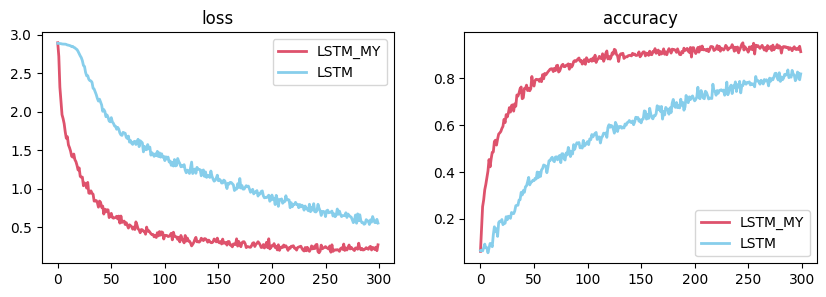

In [36]:
plot_lines(loss_lstm_my,loss_lstm[0:300], accuracy_lstm_my,accucay_lstm[0:300])

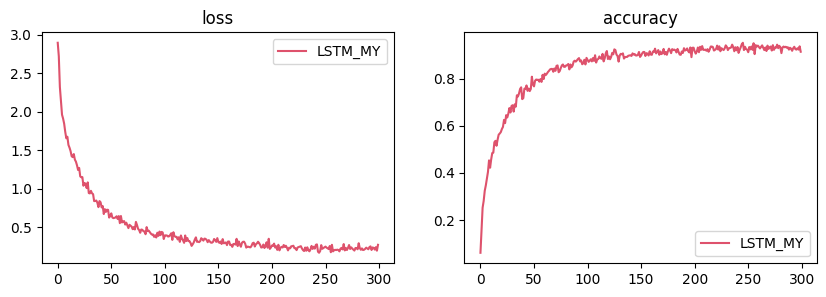

In [23]:
plot_lines(loss_lstm_my, accuracy_lstm_my)

### Evaluating the Results
To see how well the network performs on different categories, we will create a confusion matrix, indicating for every actual language (rows) which language the network guesses (columns). To calculate the confusion matrix a bunch of samples are run through the network with evaluate(), which is the same as train() minus the backprop.

You can pick out bright spots off the main axis that show which languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish for Italian. It seems to do very well with Greek, and very poorly with English (perhaps because of overlap with other languages).

In [27]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor, net):
    if net.isLSTM == True:
        h0, c0 = net.initHidden()
    else:
        h0 = net.initHidden()

    if net.isLSTM == True:
        output, h, c = net(line_tensor, h0, c0)
        return output[-1]
    else:
        for i in range(line_tensor.size()[0]):
            output, h0 = net(line_tensor[i], h0)
        return output

def plot_confusion_matrix(net):
    # Go through a bunch of examples and record which are correctly guessed
    for i in range(n_confusion):
        category, line, category_tensor, line_tensor = randomTrainingExample()
        output = evaluate(line_tensor, net)
        guess, guess_i = categoryFromOutput(output)
        category_i = all_categories.index(category)
        confusion[category_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(n_categories):
        confusion[i] = confusion[i] / confusion[i].sum()

    # Set up plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.numpy())
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + all_categories, rotation=90)
    ax.set_yticklabels([''] + all_categories)

    # Force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.savefig("lstm_matrix.png")

    # sphinx_gallery_thumbnail_number = 2
    plt.show()

/tmp/ipykernel_1152/2721348306.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_1152/2721348306.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


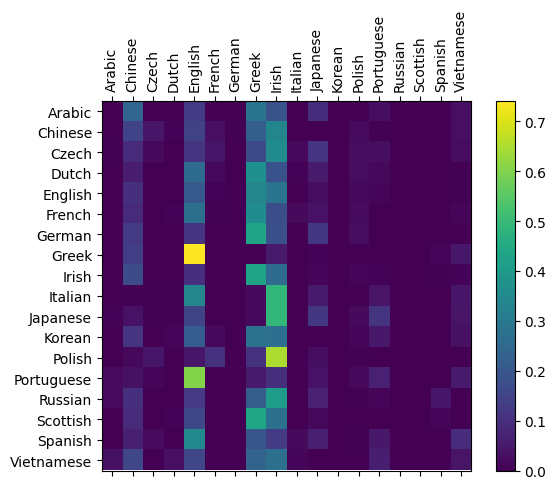

In [25]:
plot_confusion_matrix(rnn)

/tmp/ipykernel_1152/2805853206.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_1152/2805853206.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


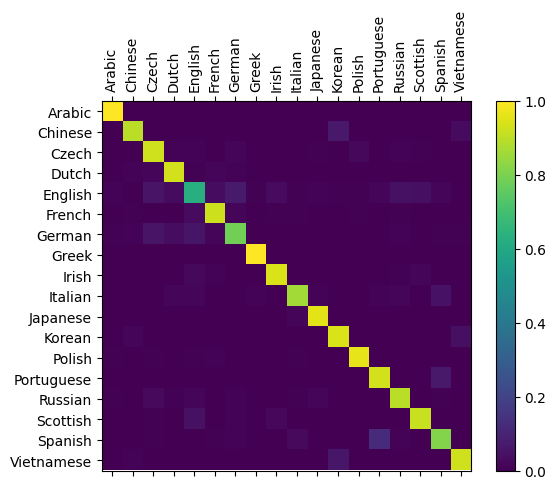

In [28]:
plot_confusion_matrix(lstm)

### Running on User Input

In [16]:
import math
import numpy as np

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (np.exp(value), all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Hou')


> Dovesky
(0.68) Russian
(0.25) Czech
(0.03) English

> Jackson
(0.70) Scottish
(0.18) English
(0.05) Russian

> Hou
(0.49) Chinese
(0.34) Korean
(0.10) Vietnamese
